# Stochastic Dissipative Qubit: Single Trajectories

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv, matrix_power, eigh, eigvalsh, eigvals
from scipy.optimize import curve_fit
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 18
mpl.rcParams['text.latex.preamble']=r'\usepackage{amsfonts}'
from scipy.linalg import expm, sqrtm
from scipy.stats import linregress
from math import acos, factorial
import matplotlib.colors as colors
from scipy.special import eval_genlaguerre, gamma, hyp1f1, erf, erfc, erfi, dawsn
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

/Users/pablo/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Average results
def A(g, G):
    return G*(-1+g*G)
def B(g, G):
    return G*(-2+4*g*G)
def C(g, G):
    return -((A(g,G)+B(g,G))/3)**2 +(4+A(g,G)*B(g,G))/3
def D(g, G):
    return (A(g,G)+B(g,G))*(4+A(g,G)*B(g,G))/3 -2*B(g,G) -2*((A(g,G)+B(g,G))/3)**3
def U(m, pm, g, G):
    return (-D(g,G)/2 +pm*np.emath.sqrt((D(g,G)/2)**2+C(g, G)**3))**(1./3.)*np.exp(1j*m*2*np.pi/3)
def discriminant_cubic(g, G):
    return ((D(g,G)/2)**2+C(g, G)**3)
def eval1(g, G):
    return A(g, G)
def eval2(g, G):
    Ump = U(0, 1, g, G)
    return (Ump -C(g,G)/Ump +(A(g,G)+B(g,G))/3)
def eval3(g, G):
    Ump = U(1, 1, g, G)
    return (Ump -C(g,G)/Ump +(A(g,G)+B(g,G))/3)
def eval4(g, G):
    Ump = U(-1, 1, g, G)
    return (Ump -C(g,G)/Ump +(A(g,G)+B(g,G))/3)
def evec1(g, G):
    return np.asarray([0,1,1,0])
def evec2(g, G):
    b0 = B(g,G)-eval2(g,G)
    b1 = 1j*(B(g,G)-2*eval2(g,G))/(-A(g,G)+eval2(g,G))
    b2 = - b1
    b3 = eval2(g,G)
    return np.asarray([b0, b1, b2, b3])/B(g,G)
    """b0 = B(g,G)/B(g,G)
    b1 = -1j*eval2(g,G)/2
    b2 = - b1
    b3 = B(g,G)/B(g,G)-eval2(g,G)*(A(g,G)-eval2(g,G))/2
    return np.asarray([b0, b1, b2, b3])/(2*B(g,G)/B(g,G)-eval2(g,G)*(A(g,G)-eval2(g,G))/2)"""
def evec3(g, G):
    b0 = B(g,G)-eval3(g,G)
    b1 = 1j*(B(g,G)-2*eval3(g,G))/(-A(g,G)+eval3(g,G))
    b2 = - b1
    b3 = eval3(g,G)
    return np.asarray([b0, b1, b2, b3])/B(g,G)
def evec4(g, G):
    b0 = B(g,G)-eval4(g,G)
    b1 = 1j*(B(g,G)-2*eval4(g,G))/(-A(g,G)+eval4(g,G))
    b2 = - b1
    b3 = eval4(g,G)
    return np.asarray([b0, b1, b2, b3])/B(g,G)
def zBloch(g, G):
    λ0 = eval2(g, G)
    return -λ0*(λ0-A(g,G))/(4 + λ0*(λ0-A(g,G)))
def yBloch(g, G):
    λ0 = eval2(g, G)
    return 2*λ0/(4 + λ0*(λ0-A(g,G)))
def gap(g, G):
    diff_arr = np.asarray([eval2(g,G)-eval1(g, G),\
                           eval2(g,G)-np.real(eval3(g, G)),\
                           eval2(g,G)-np.real(eval4(g, G))])
    return np.min(diff_arr, axis = 0)
def maxI(g, G):
    return np.abs(np.imag(eval3(g, G)))

The SME normalized at single trajectories (no average) reads:
$$\dot \varrho = (\mathcal L[\varrho] - \text{Tr}(\mathcal L[\varrho])\varrho) dt+(\mathcal M[\varrho] - \text{Tr}(\mathcal M[\varrho])\varrho) dW_t,$$
where $\mathcal L, \mathcal M$ are two non-TP superoperators defined as
$$\mathcal L[\bullet] = - i [H_0, \bullet] -\{L, \bullet\} + \gamma \{L, \{L, \bullet\}\}$$
$$\mathcal M[\bullet] = -\sqrt{2 \gamma}\{L, \bullet\}$$
For the SDQ we take $H_0 = J \sigma_x$ and $L = (1-\sigma_z)/2$. The equations of motion for the Bloch coordinates read
$$\begin{cases}
     d x =\left( -(\gamma \Gamma_e^2 + z \Gamma_e( 1 - 2 \gamma \Gamma_e))x\right)  d t - \sqrt{2 \gamma} \Gamma_e x z  d W_t\\
     d y = \left( - 2 J z -(\gamma \Gamma_e^2 + z \Gamma_e( 1 - 2 \gamma \Gamma_e))y \right)  d t - \sqrt{2 \gamma} \Gamma_e y z  d W_t \\
     d z =   \left(2 J y - \Gamma_e (1 - 2 \gamma \Gamma_e) (z^2 - 1) \right)  d t  - \sqrt{2 \gamma} \Gamma_e (z^2 - 1)  d W_t
\end{cases}$$
Taking an initial state with $x=0$ ensures that the variable $x$ does not evolve so that the dynamics can be rreduced to $y,z$. In a similar way one may write these two equations in polar coordinates to find 
$$\begin{cases}
 d r = \dfrac{\Gamma_e \left(r^2-1\right) \left(r (2 \gamma \Gamma_e-1) \cos (\theta )-\gamma \Gamma_e \sin ^2(\theta )\right)}{r}  dt- \sqrt{2 \gamma} \Gamma_e \left(r^2-1\right) \cos (\theta
   ) dW_t\\
    d \theta = -\dfrac{\sqrt{2 \gamma} \Gamma_e \sin (\theta )}{r}\text{d}W_t+ \left(-\dfrac{\Gamma_e \sin (\theta )
   \left(\gamma \Gamma_e \left(3 r^2-2\right) \cos (\theta )-2 \gamma \Gamma_e r+r\right)}{r^2}-2
   J\right)\text{d} t
\end{cases}$$
the first equation describes the purity evolution of mixed states, and the seocnd the angular position in the Bloch sphere. When $r=1$ the first equation vanishes since pure state remain pure by a non hermitian hamitlonian and we find that the second one reduces to
$$d \theta = -\sqrt{2 \gamma} \Gamma_e \sin (\theta )\text{d}W_t- \left(2
   J + \Gamma_e(1 - 2 \gamma \Gamma_e + \gamma \Gamma_e \cos(\theta))\sin(\theta)\right)\text{d} t.$$

Stochastic Integrator: Explicit Order 1.5 strong scheme (for autonomous 1D case) [Kloeden, PLaten book, chapt 11.2] (eqs 2.1, 2.2, 2.3 pg 378)
\begin{align}
Y_{n+1} = &Y_n + b \Delta W + \frac{a(\Upsilon_+)-a(\Upsilon_-)}{2 \sqrt{\Delta t}}\Delta Z\\
&+ \frac{a(\Upsilon_+)+ 2 a + a(\Upsilon_-)}{4}\Delta t + \frac{b(\Upsilon_+)-b(\Upsilon_-)}{4\sqrt{\Delta t} }(\Delta W^2 - \Delta t) \\
&+ \frac{b(\Upsilon_+) - 2 b + b(\Upsilon_-)}{2 \Delta t}(\Delta W \Delta t - \Delta Z)\\
&+ \frac{b(\Phi_+)-b(\Phi_-)-b(\Upsilon_+)+b(\Upsilon_-)}{4 \Delta t}\left(\frac{\Delta W^2}{3}-\Delta t\right)\Delta W,
\end{align}
where $a\equiv a(Y_n), \; b \equiv b(Y_n)$, $\Delta t$ is the time step, the auxiliary variables are
$$\Upsilon_\pm = Y_n + a \Delta t \pm b \sqrt{\Delta t}, \qquad \Phi_\pm = \Upsilon_+ \pm b(\Upsilon_+)\sqrt{\Delta t},$$ 
and the noises $\Delta W, \; \Delta Z$ are found from the transformation  (eq. 4.3 pg 352)
$$\Delta W = U_1 \sqrt{\Delta t}, \qquad \Delta Z = \frac{\Delta t^{3/2}}{2}(U_1 + \tfrac{1}{\sqrt{3}}U_2),$$
where $U_1, U_2 \sim \mathcal N(0,1)$ are i.i.d. normal random variables.

In [3]:
#pure single trajectories
"""#@numba.njit()
def detF(θ, t, γ, Γe, J):
    out = - 2.*J - Γe*(1-2.*γ*Γe+γ*Γe*np.cos(θ))*np.sin(θ)
    #only noise
    #out =  - Γe*(-2.*γ*Γe+γ*Γe*np.cos(θ))*np.sin(θ)
    return out
#@numba.njit()
def stochF(θ, t, γ, Γe, J):
    out = np.sqrt(2*γ)*Γe*np.sin(θ)
    return out
#@numba.njit()"""
#general single trajectories
#@numba.njit()
def detF(sol, t, γ, Γe, J):
    #out = - 2.*J - Γe*(1-2.*γ*Γe+γ*Γe*np.cos(θ))*np.sin(θ)
    #only noise
    #out =  - Γe*(-2.*γ*Γe+γ*Γe*np.cos(θ))*np.sin(θ)
    x = sol[0]
    y = sol[1]
    z = sol[2]
    out1 = np.sqrt(2)*J*z-(γ*Γe**2+z*Γe*(1-2*γ*Γe))*x
    out2 = -np.sqrt(2)*J*z-(γ*Γe**2+z*Γe*(1-2*γ*Γe))*y
    out3 = np.sqrt(2)*J*(y-x)-Γe*(1-2*γ*Γe)*(z**2-1)
    out = np.asarray([out1, out2, out3])
    return out
#@numba.njit()
def stochF(sol, t, γ, Γe, J):
    x = sol[0]
    y = sol[1]
    z = sol[2]
    out1 = -np.sqrt(2*γ)*Γe*x*z
    out2 = -np.sqrt(2*γ)*Γe*y*z
    out3 = -np.sqrt(2*γ)*Γe*(z**2-1)
    out = np.asarray([out1, out2, out3])
    return out
#@numba.njit()
#scalar variable
"""def StochIntegrator(y0, t_arr, pars, ξ, N_t, dt):
    #dt = t_arr[1]-t_arr[0]
    sol = np.zeros(N_t)
    sol[0] = y0
    #Kloeden-Platen explicit order 1.5 strong scheme
    for n in range(1, N_t):
        aYn = detF(sol[n-1], t_arr[n-1], pars[0], pars[1], pars[2])
        bYn = stochF(sol[n-1], t_arr[n-1], pars[0], pars[1], pars[2])
        #aux variables
        UpsP = sol[n-1] + aYn*dt + bYn*np.sqrt(dt)
        UpsM = sol[n-1] + aYn*dt - bYn*np.sqrt(dt)
        aUpsP = detF(UpsP, t_arr[n-1], pars[0], pars[1], pars[2])
        aUpsM = detF(UpsM, t_arr[n-1], pars[0], pars[1], pars[2])
        bUpsP = stochF(UpsP, t_arr[n-1], pars[0], pars[1], pars[2])
        bUpsM = stochF(UpsM, t_arr[n-1], pars[0], pars[1], pars[2])
        PhiP = UpsP + bUpsP*np.sqrt(dt)
        PhiM = UpsP - bUpsP*np.sqrt(dt)
        bPhiP = stochF(PhiP, t_arr[n-1], pars[0], pars[1], pars[2])
        bPhiM = stochF(PhiM, t_arr[n-1], pars[0], pars[1], pars[2])
        #Random variables 
        U1 = ξ[n,0]
        U2 = ξ[n,1]
        ΔW = U1*np.sqrt(dt)
        ΔZ = dt**(3/2)/2*(U1+U2/np.sqrt(3))
        #solution
        sol[n] = sol[n-1] + bYn*ΔW + (aUpsP - aUpsM)*ΔZ/(2*np.sqrt(dt))\
        + (aUpsP + 2*aYn + aUpsM)*dt/4 + (bUpsP - bUpsM)*(ΔW**2 - dt)/(4*np.sqrt(dt))\
        + (bUpsP - 2*bYn + bUpsM)*(ΔW*dt - ΔZ)/(2*dt)\
        + (bPhiP - bPhiM - bUpsP + bUpsM)*(ΔW**2/3 - dt)*ΔW/(4*dt)
    #RK2
    for n in range(1, N_t):
        aYn = detF(sol[n-1], 0, pars[0], pars[1], pars[2])
        bYn = stochF(sol[n-1], 0, pars[0], pars[1], pars[2])
        #ΔWn = np.random.normal(0, dt)
        ΔWn = ξ[n]
        varYn = sol[n-1] + aYn*dt + bYn*np.sqrt(dt)
        bvarYn = stochF(varYn, 0, pars[0], pars[1], pars[2])
        sol[n] = sol[n-1] + aYn*dt + bYn*ΔWn +0.5*(bvarYn-bYn)*(ΔWn**2-dt)*dt**(-0.5)
    #Euler  Maruyama
    for n in range(1, len(t_arr)):
        aYn = func(0, sol[:,n-1], pars)
        bYn = stochF(0, sol[:, n-1], pars)
        ΔWn = np.random.normal(0, dt)
        sol[:,n] = sol[:,n-1] + aYn*dt + bYn*ΔWn
    #Rossler
    #for n in range(1, len(t_arr))
    return sol"""
#2d integrator
def StochIntegrator(y0, t_arr, pars, ξ, N_t, dt):
    #dt = t_arr[1]-t_arr[0]
    sol = np.zeros((3,N_t))
    sol[:,0] = y0
    #Kloeden-Platen explicit order 1.5 strong scheme
    for n in range(1, N_t):
        aYn = detF(sol[:,n-1], t_arr[n-1], pars[0], pars[1], pars[2])
        bYn = stochF(sol[:,n-1], t_arr[n-1], pars[0], pars[1], pars[2])
        #aux variables
        UpsP = sol[:,n-1] + aYn*dt + bYn*np.sqrt(dt)
        UpsM = sol[:,n-1] + aYn*dt - bYn*np.sqrt(dt)
        aUpsP = detF(UpsP, t_arr[n-1], pars[0], pars[1], pars[2])
        aUpsM = detF(UpsM, t_arr[n-1], pars[0], pars[1], pars[2])
        bUpsP = stochF(UpsP, t_arr[n-1], pars[0], pars[1], pars[2])
        bUpsM = stochF(UpsM, t_arr[n-1], pars[0], pars[1], pars[2])
        PhiP = UpsP + bUpsP*np.sqrt(dt)
        PhiM = UpsP - bUpsP*np.sqrt(dt)
        bPhiP = stochF(PhiP, t_arr[n-1], pars[0], pars[1], pars[2])
        bPhiM = stochF(PhiM, t_arr[n-1], pars[0], pars[1], pars[2])
        #Random variables 
        U1 = ξ[n,0]
        U2 = ξ[n,1]
        ΔW = U1*np.sqrt(dt)
        ΔZ = dt**(3/2)/2*(U1+U2/np.sqrt(3))
        #solution
        sol[:,n] = sol[:,n-1] + bYn*ΔW + (aUpsP - aUpsM)*ΔZ/(2*np.sqrt(dt))\
        + (aUpsP + 2*aYn + aUpsM)*dt/4 + (bUpsP - bUpsM)*(ΔW**2 - dt)/(4*np.sqrt(dt))\
        + (bUpsP - 2*bYn + bUpsM)*(ΔW*dt - ΔZ)/(2*dt)\
        + (bPhiP - bPhiM - bUpsP + bUpsM)*(ΔW**2/3 - dt)*ΔW/(4*dt)
    #RK2
    """for n in range(1, N_t):
        aYn = detF(sol[n-1], 0, pars[0], pars[1], pars[2])
        bYn = stochF(sol[n-1], 0, pars[0], pars[1], pars[2])
        #ΔWn = np.random.normal(0, dt)
        ΔWn = ξ[n]
        varYn = sol[n-1] + aYn*dt + bYn*np.sqrt(dt)
        bvarYn = stochF(varYn, 0, pars[0], pars[1], pars[2])
        sol[n] = sol[n-1] + aYn*dt + bYn*ΔWn +0.5*(bvarYn-bYn)*(ΔWn**2-dt)*dt**(-0.5)"""
    #Euler  Maruyama
    """for n in range(1, len(t_arr)):
        aYn = detF(sol[n-1], t_arr[n-1], pars[0], pars[1], pars[2])
        bYn = stochF(sol[n-1], t_arr[n-1], pars[0], pars[1], pars[2])
        ΔWn = np.random.normal(0, np.sqrt(dt))
        sol[n] = sol[n-1] + aYn*dt + bYn*ΔWn"""
    #Rossler
    #for n in range(1, len(t_arr))
    return sol

In [4]:
#averaging over initial condition
"""def compute_trajs(y0, t_arr, pars, Nav, N_t, N_av_th, width):
    out_trajs = np.zeros((N_t, Nav, N_av_th))
    dt = t_arr[1] - t_arr[0]
    for n in range(N_av_th):
        y0_dis = y0 + np.random.uniform(-width/2, width/2)
        for k in range(Nav):
            ξ = np.random.randn(N_t, 2)
            out_trajs[:,k,n] = StochIntegrator(y0_dis, t_arr, pars, ξ, N_t, dt)
    return out_trajs"""
#No avging over initial condition
def compute_trajs(y0, t_arr, pars, Nav, N_t):
    out_trajs = np.zeros((3,N_t, Nav))
    out_trajs_SRE = np.zeros((N_t, Nav))
    dt = t_arr[1] - t_arr[0]
    for k in range(Nav):
        ξ = np.random.randn(N_t, 2)
        out_trajs[:,:,k] = StochIntegrator(y0, t_arr, pars, ξ, N_t, dt)
        out_trajs_SRE[:,k] = tildeSRE_st(out_trajs[0,:,k], out_trajs[1,:,k], out_trajs[2,:,k])
    return out_trajs, out_trajs_SRE
def fx(x, y, z, G, g, t):
    return (-(g*G**2+ z*G*(1-2*G*g))*x/2)*2
def fy(x, y, z, G, g, t):
    return (-z-(g*G**2+ z*G*(1-2*G*g))*y/2)*2
def fz(x, y, z, G, g, t):
    return (y-G*(1-2*g*G)*(z**2-1)/2)*2
def F(r, t, G, g):
    return np.asarray([fx(r[0], r[1], r[2], G, g, t), \
                       fy(r[0], r[1], r[2], G, g, t), \
                       fz(r[0], r[1], r[2], G, g, t)])
def RK4_integrator(rn, tn, dt, G, g):
    k1 = F(rn, tn, G, g)
    k2 = F(rn+dt*k1/2, tn+dt/2, G, g)
    k3 = F(rn+dt*k2/2, tn+dt/2, G, g)
    k4 = F(rn+dt*k3, tn+dt, G, g)
    rnp1 = rn + dt/6*(k1+2*k2+2*k3+k4)
    return rnp1
def compute_trajs_av(r0, t_arr, N_t, G, g):
    r_arr = np.zeros((3, N_t))
    dt = t_arr[1] - t_arr[0]
    r_arr[:,0] = r0
    for n in range(1, N_t):
        r_arr[:, n] = RK4_integrator(r_arr[:,n-1], t_arr[n-1], dt, G, g)
    return r_arr
#y,z are single values, not arrays
def tildeSRE_st(x,y,z):
    #print(y)
    aux_log = (1**4 + x**4+ y**4 + z**4)/(1 + x**2+y**2+z**2)
    """
    L = np.abs(y) + np.abs(z)
    if L>1:
        return -np.log(aux_log)/np.log(2)
    else:
        return 0"""
    return -np.log(aux_log)/np.log(2)
def tildeSRE_trajs(trajs, N_av_th):
    z_aux = np.zeros(N_av_th)
    y_aux = np.zeros(N_av_th)
    SRE_aux = np.zeros(N_av_th)
    for n in range(N_av_th):
        z_aux[n] =  np.average(np.cos(trajs[-1, :, n]))
        y_aux[n] =  np.average(np.sin(trajs[-1, :, n]))
        SRE_aux[n] = tildeSRE_st(y_aux[n],z_aux[n])
    return np.average(SRE_aux)

In [5]:
"""#single set of parameters
γ = 0.02
Γe = 50
J = 1
pars = np.asarray([γ, Γe, J])
N_t = 2000
t_arr2 = np.linspace(0, 5, N_t)
#print(t_arr[1])
N_av = 50
θ_0 = 0.9438
trajs = compute_trajs(θ_0, t_arr2, pars, N_av, N_t)"""

'#single set of parameters\nγ = 0.02\nΓe = 50\nJ = 1\npars = np.asarray([γ, Γe, J])\nN_t = 2000\nt_arr2 = np.linspace(0, 5, N_t)\n#print(t_arr[1])\nN_av = 50\nθ_0 = 0.9438\ntrajs = compute_trajs(θ_0, t_arr2, pars, N_av, N_t)'

In [6]:
"""#print(trajs)
#plt.figure()
fig, axs = plt.subplots(2,1,sharex = True, sharey = True, figsize = [5,4])
plt.subplots_adjust(hspace = 0.)
for n in range(N_av):
    axs[0].plot(t_arr2, np.cos(trajs[:,n]), c = 'gray', lw = 0.5, zorder = 0)
    axs[1].plot(t_arr2, np.sin(trajs[:,n]), c = 'gray', lw = 0.5, zorder = 0)
#plt.ylim(0.986, 1)
avg_z = np.average(np.cos(trajs), axis=1)
std_z = np.std(np.cos(trajs), axis=1)
avg_y = np.average(np.sin(trajs), axis=1)
std_y = np.std(np.sin(trajs), axis=1)
axs[0].plot(t_arr2, avg_z, c = 'b', lw = 2)
axs[0].plot(t_arr2, avg_z-std_z, c = 'b', lw = 0.5, ls = '--')
axs[0].plot(t_arr2, avg_z+std_z, c = 'b', lw = 0.5, ls = '--')
axs[0].fill_between(t_arr2, avg_z-std_z, avg_z+std_z, color = 'b', alpha = 0.2)
axs[1].plot(t_arr2, avg_y, c = 'b', lw = 2)
axs[1].plot(t_arr2, avg_y-std_y, c = 'b', lw = 0.5, ls = '--')
axs[1].plot(t_arr2, avg_y+std_y, c = 'b', lw = 0.5, ls = '--')
axs[1].fill_between(t_arr2, avg_y-std_y, avg_y+std_y, color = 'b', alpha = 0.2)
axs[0].set_ylabel("$z(t)$")
axs[1].set_ylabel("$y(t)$")
axs[1].set_xlabel("$t$")
plt.xlim(t_arr2[0], t_arr2[-1])
#axs[1].set_xscale('log')
axs[0].set_title(r"$\gamma="+str(γ)+",\; \Gamma_e ="+str(Γe)+",\; J="+str(J)+"$")
plt.savefig("SDQ_single_trajs_NI.pdf", bbox_inches = 'tight')
plt.show()"""


'#print(trajs)\n#plt.figure()\nfig, axs = plt.subplots(2,1,sharex = True, sharey = True, figsize = [5,4])\nplt.subplots_adjust(hspace = 0.)\nfor n in range(N_av):\n    axs[0].plot(t_arr2, np.cos(trajs[:,n]), c = \'gray\', lw = 0.5, zorder = 0)\n    axs[1].plot(t_arr2, np.sin(trajs[:,n]), c = \'gray\', lw = 0.5, zorder = 0)\n#plt.ylim(0.986, 1)\navg_z = np.average(np.cos(trajs), axis=1)\nstd_z = np.std(np.cos(trajs), axis=1)\navg_y = np.average(np.sin(trajs), axis=1)\nstd_y = np.std(np.sin(trajs), axis=1)\naxs[0].plot(t_arr2, avg_z, c = \'b\', lw = 2)\naxs[0].plot(t_arr2, avg_z-std_z, c = \'b\', lw = 0.5, ls = \'--\')\naxs[0].plot(t_arr2, avg_z+std_z, c = \'b\', lw = 0.5, ls = \'--\')\naxs[0].fill_between(t_arr2, avg_z-std_z, avg_z+std_z, color = \'b\', alpha = 0.2)\naxs[1].plot(t_arr2, avg_y, c = \'b\', lw = 2)\naxs[1].plot(t_arr2, avg_y-std_y, c = \'b\', lw = 0.5, ls = \'--\')\naxs[1].plot(t_arr2, avg_y+std_y, c = \'b\', lw = 0.5, ls = \'--\')\naxs[1].fill_between(t_arr2, avg_y-std_y,

In [18]:
#Sweeping in Γ
J = 1 #broken PT
#G_arr = np.asarray([1, 2, 3])
i = complex(0,1)
NpG = 40
#aux = np.linspace(-2, 0.8, Np)
#g_arr = 10**aux
auxG = np.linspace(-0.5, 1, NpG)
G_arr = 10**auxG
Npg = 60
auxg = np.linspace(-3, 1, Npg)
g_arr = 10**auxg
#g_arr = np.asarray([0.03])
#tf = 13
Nt = 70
N_av = 40
x0 = 0
y0 = 0
z0 = 0
sol0_arr = np.asarray([x0, y0, z0])
#N_av_th = 10
#θ_0 = 1.9438
#width = 0.8
#t_arr = np.linspace(0, tf, Nt)
#dt = t_arr[1]-t_arr[0]
#r_arr = np.zeros((3, Nt, len(G_arr), len(g_arr)))
#purity_t = np.zeros((Nt, len(G_arr), len(g_arr)))
#t_arr_Arr = np.zeros((Nt, len(G_arr), len(g_arr)))
#fidelity = np.zeros((Nt, len(g_arr), len(G_arr)), dtype = complex)
#z_coord = np.zeros((len(g_arr), len(G_arr), N_av_th))
#Δz_coord = np.zeros((Nt, len(g_arr), len(G_arr)))
#y_coord = np.zeros((len(g_arr), len(G_arr), N_av_th))
SRE_fin = np.zeros((len(g_arr), len(G_arr)))
#Δy_coord = np.zeros((Nt, len(g_arr), len(G_arr)))
#diffy_av = np.zeros((Nt, len(g_arr), len(G_arr)))
#diffz_av = np.zeros((Nt, len(g_arr), len(G_arr)))
#OTOC = np.zeros((Nt, len(g_arr), len(G_arr)))
#Rem_norm = np.zeros((len(g_arr), len(G_arr)))
trajs = np.zeros((3, Nt, N_av, len(g_arr), len(G_arr)))
tilde_SRE_trajs = np.zeros((Nt, N_av, len(g_arr), len(G_arr)))
avg_x = np.zeros((Nt, len(g_arr), len(G_arr)))
avg_y = np.zeros((Nt, len(g_arr), len(G_arr)))
avg_z = np.zeros((Nt, len(g_arr), len(G_arr)))
#t_arr_Arr[:,m,k] = t_arr
#dt = t_arr[1]-t_arr[0]

#r0 = np.asarray([0, np.sin(θ_0), np.cos(θ_0)])
gap_arr_aux = np.zeros((len(g_arr), len(G_arr)))
for n in range(len(g_arr)):
    for m in range(len(G_arr)):
        Δ = gap(g_arr[n], G_arr[m])
        gap_arr_aux[n,m] = Δ
        #ω = maxI(g_arr[k], G_arr[m])
        t_arr = np.linspace(0, 3/Δ, Nt)
        """if ω < Δ:
            t_arr = np.linspace(0, 10/Δ, Nt)
        else:
            Δt = np.pi/(2*ω)/2
            t_arr = np.linspace(0, Nt*Δt, Nt)"""
        dt = t_arr[1]-t_arr[0]
        pars = np.asarray([g_arr[n], G_arr[m], J])
        #trajs = compute_trajs(θ_0, t_arr, pars, N_av, Nt, N_av_th, width)
        #print(trajs)
        trajs[:,:,:,n, m], tilde_SRE_trajs[:,:,n, m] = compute_trajs(sol0_arr, t_arr, pars, N_av, Nt)
        avg_x[:,n, m] = np.average(trajs[0,:,:,n, m], axis = 1)
        avg_y[:,n, m] = np.average(trajs[1,:,:,n, m], axis = 1)
        avg_z[:,n, m] = np.average(trajs[2,:,:,n, m], axis = 1)
        SRE_fin[n,m] = tildeSRE_st(avg_x[-1,n,m], avg_y[-1,n,m], avg_z[-1,n,m])
        #z_coord[k,m] = np.average(np.cos(trajs[-1, :]))
        #Δz_coord[:,k,m] = np.std(np.cos(trajs), axis = 1)
        #y_coord[k,m] = np.average(np.sin(trajs[-1, :]))
        #SRE_fin[k,m] = tildeSRE_trajs(trajs,N_av_th)
        #Δy_coord[:,k,m] = np.std(np.sin(trajs), axis = 1)
        #vecr_coord_av = compute_trajs_av(r0, t_arr, Nt, G_arr[m], g_arr[k])
        #diffy_av = y_coord[k,m]-vecr_coord_av[1,-1]
        #diffz_av = z_coord[k,m]-vecr_coord_av[2,-1]
        #Rem_norm[k,m] = (diffy_av**2+diffz_av**2)/2
        #r = np.sqrt(z_coord[:,k,m]**2 + y_coord[:,k,m]**2)
        #av_θ = np.arctan2(y_coord[:,k,m], z_coord[:,k,m])
        #OTOC[:,k,m] = (-1 - 3*r**2/4 + 2*r*np.cos(av_θ)- r**2/4*np.cos(2*av_θ))
        #OTOC[:,k,m] = g_arr[k]*G_arr[m]**2*(-1 - 3*r**2/4 + 2*r*np.cos(av_θ)- r**2/4*np.cos(2*av_θ))

/var/folders/4d/0pzsm1ss5sg4jpm1h6g431qm0000gn/T/ipykernel_6586/4032153169.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  gap_arr_aux[n,m] = Δ
/var/folders/4d/0pzsm1ss5sg4jpm1h6g431qm0000gn/T/ipykernel_6586/904758210.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  sol[:,n] = sol[:,n-1] + bYn*ΔW + (aUpsP - aUpsM)*ΔZ/(2*np.sqrt(dt))\
/var/folders/4d/0pzsm1ss5sg4jpm1h6g431qm0000gn/T/ipykernel_6586/904758210.py:32: RuntimeWarning: overflow encountered in scalar multiply
  out1 = -np.sqrt(2*γ)*Γe*x*z
/var/folders/4d/0pzsm1ss5sg4jpm1h6g431qm0000gn/T/ipykernel_6586/904758210.py:33: RuntimeWarning: overflow encountered in scalar multiply
  out2 = -np.sqrt(2*γ)*Γe*y*z
/var/folders/4d/0pzsm1ss5sg4jpm1h6g431qm0000gn/T/ipykernel_6586/904758210.py:34: RuntimeWarning: overflow encountered in scalar power
  out3 = -np.sqrt(2*γ)*Γe*(z**2-1)
/var/folders/4d/0pzsm1ss5sg4jpm1h6g431qm0000gn/T/ipykernel_6586/904758210.py:34: RuntimeW

/var/folders/4d/0pzsm1ss5sg4jpm1h6g431qm0000gn/T/ipykernel_6586/904758210.py:114: RuntimeWarning: overflow encountered in add
  + (bUpsP - 2*bYn + bUpsM)*(ΔW*dt - ΔZ)/(2*dt)\
/var/folders/4d/0pzsm1ss5sg4jpm1h6g431qm0000gn/T/ipykernel_6586/904758210.py:112: RuntimeWarning: invalid value encountered in divide
  sol[:,n] = sol[:,n-1] + bYn*ΔW + (aUpsP - aUpsM)*ΔZ/(2*np.sqrt(dt))\
/var/folders/4d/0pzsm1ss5sg4jpm1h6g431qm0000gn/T/ipykernel_6586/904758210.py:96: RuntimeWarning: overflow encountered in add
  UpsP = sol[:,n-1] + aYn*dt + bYn*np.sqrt(dt)
/var/folders/4d/0pzsm1ss5sg4jpm1h6g431qm0000gn/T/ipykernel_6586/904758210.py:112: RuntimeWarning: invalid value encountered in add
  sol[:,n] = sol[:,n-1] + bYn*ΔW + (aUpsP - aUpsM)*ΔZ/(2*np.sqrt(dt))\
/var/folders/4d/0pzsm1ss5sg4jpm1h6g431qm0000gn/T/ipykernel_6586/2085841392.py:48: RuntimeWarning: overflow encountered in scalar power
  aux_log = (1**4 + x**4+ y**4 + z**4)/(1 + x**2+y**2+z**2)


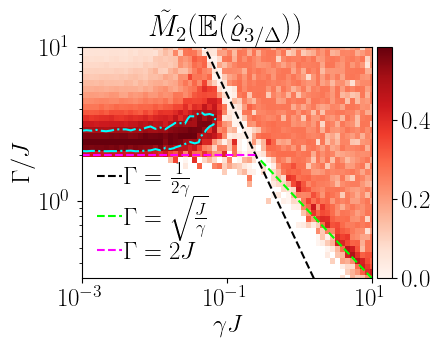

In [20]:
fig, ax = plt.subplots(1, 1, sharex = True, sharey = True ,figsize = [4,3])
#cm2 = colors.LinearSegmentedColormap.from_list("", ["cyan", "magenta", "lime"])
plt.subplots_adjust(wspace = 0.21, hspace = 0.21)
#cm1 = plt.get_cmap('RdBu')
cm2 = plt.get_cmap('Reds')
#cm3 = plt.get_cmap('Blues')
#cm4 = plt.get_cmap('GnBu')
#cm4 = plt.get_cmap('PRGn')
#cm4 = plt.get_cmap('RdBu')
#aux_arr = np.real(evec_St[0, :,:]-evec_St[3, :,:])
#aux_arr2 = np.imag(evec_St[2, :,:])*2
#aux_arr2 = np.sum(np.abs(evec_St[:, :,:])**2, axis = 0)
#aux_arr2 = max_R
#p1=ax.pcolormesh( g_arr, G_arr,np.transpose(np.log(np.abs(aux_arr))), cmap = 'inferno')
#p1=ax1.pcolormesh( g_arr, G_arr,np.transpose(aux_arr), cmap = cm1, shading = 'gouraud', vmin=-1, vmax=1)
#p1=ax[0].pcolormesh(g_arr, G_arr,np.transpose(z_coord), cmap = cm1, shading = 'auto', rasterized = 'False', vmin = -1, vmax = 1)
#p2=ax[1].pcolormesh(g_arr, G_arr,np.transpose(y_coord), cmap = cm1, shading = 'auto', rasterized = 'False', norm = colors.TwoSlopeNorm(vmin = -1, vcenter =0, vmax = 0.5))
p3=ax.pcolormesh( g_arr, G_arr,np.transpose(SRE_fin), cmap = cm2, shading = 'auto', rasterized = 'False', vmin = 0)
plt.contour(g_arr, G_arr, np.transpose(SRE_fin), [0.5], colors = 'cyan', linestyles = '-.')
#p4=ax[1].pcolormesh( g_arr, G_arr,np.transpose(aux_arr2), cmap = cm4, shading = 'gouraud', rasterized = 'False', norm = colors.TwoSlopeNorm(vmin = -1, vcenter =0))
#p4=ax[1,1].pcolormesh( g_arr, G_arr,np.transpose(aux_arr2), cmap = cm1, shading = 'gouraud', vmin = -0.4, vmax = 0.4)
#ax.scatter(g_crit, np.zeros(len(G_arr)), c = G_arr, cmap = cm2, s = 25, zorder = 10, marker = '^', edgecolor='w')
#ax.set_ylim(-1, 1)
#p1 = ax.scatter(-np.ones(len(G_arr)), np.zeros(len(G_arr)), cmap = cm2, c = G_arr, norm =colors.LogNorm(vmin = G_arr[0], vmax = G_arr[-1]))
#divider1 = make_axes_locatable(ax[0])
#cax1 = divider1.append_axes('right', size='5%', pad=0.05)
#divider2 = make_axes_locatable(ax[1])
#cax2 = divider2.append_axes('right', size='5%', pad=0.05)
divider3 = make_axes_locatable(ax)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
#divider4 = make_axes_locatable(ax[1,1])
#cax4 = divider4.append_axes('right', size='5%', pad=0.05)
#cb1 = plt.colorbar(p1, cax = cax1, ticks = [-1,0,1])
#cb2 = plt.colorbar(p2, cax = cax2, ticks = [-1,0,0.5])
cb3 = plt.colorbar(p3, cax = cax3)
#cb4 = plt.colorbar(p4, cax = cax4, ticks = [-0.4, 0, 0.4])
#cb4 = plt.colorbar(p4, cax = cax4, ticks = [-1, 0, 0.5])
#cb2.ax.set_yticks([1e-3, 1e-1, 1e1, 1e3])
#cb.ax.set_yticklabels([1e-3, 1e3])
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(g_arr[1], 3)
#ax.plot(g_crit, G_arr, ls ='--', c ='k', lw = 1)
text_arr = np.asarray(['(a)', '(b)','(c)'])
lw_val = 2
titles_arr = np.asarray([r'$z(\hat \rho^{\rm S})$', r'$y(\hat \rho^{\rm S})$', r"$||\hat R||$"])
#titles_arr = np.asarray([[r'$\Delta$', r'$\mathrm{max}(\lambda_I)$'], [r'$\rho^\mathrm{S}_{ff}-\rho^\mathrm{S}_{ee}$', r'$\mathrm{Im}(\rho^\mathrm{S}_{ef})$']])
"""for j in range(3):
    ax[j].plot(2/(4*G_arr), G_arr, ls = '--', c = 'k', lw = lw_val, alpha = 1, label = r"$\gamma = \frac{1}{2 \Gamma}$")
    ax[j].hlines(2,g_arr[0], 1/4, color = 'gray', ls ='--', lw = lw_val, label = r"$\frac{\Gamma}{J}=2$")
    ax[j].plot(1/(np.sqrt(3)*G_arr[G_arr<2]**2), G_arr[G_arr<2], ls = '--', c = 'lime', lw = lw_val, label =r"$\gamma = 2\Gamma^{-2}$")
    #ax[j].text(1e-4, 2e3, text_arr[j,k])
    ax[j].set_title(titles_arr[j])
        #ax[j,k].set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])
        #ax[j,k].plot(2/(3*G_arr), G_arr, ls = '-', c = 'k', lw = 1, alpha = 1)"""
ax.plot(1/(2*G_arr), G_arr, ls = '--', c = 'k', lw = 1.5, alpha = 1, label = r"$\Gamma = \frac{1}{2\gamma}$")
ax.plot(1/(G_arr[G_arr<2]**2), G_arr[G_arr<2], ls = '--', c = 'lime', lw = 1.5, alpha = 1, label = r"$\Gamma = \sqrt{\frac{J}{\gamma}}$")
#ax[0].set_title(r"$\Delta$")
#ax[0,0].set_title(r"$\rho^\mathrm{S}_{ff}-\rho^\mathrm{S}_{ee}$")
ax.set_xlabel(r"$\gamma J$")
#ax[1].set_xlabel(r"$\gamma J$")
#ax[2].set_xlabel(r"$\gamma J$")
#ax.contour( g_arr, G_arr,np.transpose(SRE_fin),[0.41])
#ax2.set_xlabel(r"$\gamma J$")
ax.set_ylabel(r"$\Gamma/J$")
ax.set_ylim(G_arr[0], G_arr[-1])
#ax[1,0].text(1e0, 2, r"$\gamma = 1/(2\Gamma)$")
#ax[1,0].text(1e0, 2, r"$\gamma = \Gamma^{-2}$")
#ax[1,0].text(1e-1, 2, r"$\Gamma/J = 2$")
#ax.set_yticks([-1, 0, 1])
#ax.set_yticklabels([-1, 0, 1])
#ax[0,0].set_xticks([1e-3, 1e-1, 1e1, 1e3])
#ax[0,0].set_yticks([1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])
"""SRE_fin_aux = np.copy(SRE_fin)
for n in range(len(g_arr)):
    for m in range(len(G_arr)):
        if G_arr[m]<2 and g_arr[n]<1/(2*G_arr[m]):
            SRE_fin_aux[n,m] = 0
aux = np.nanargmax(SRE_fin_aux, axis = 1)
Gst = G_arr[aux]
ax.plot(g_arr[g_arr<0.08], Gst[g_arr<0.08], c = 'orange', zorder = 10)
ax.plot(g_arr[g_arr>0.12], Gst[g_arr>0.12], c = 'orange', zorder = 10)"""
ax.set_title(r"$\tilde M_2(\mathbb E(\hat \varrho_{3/\Delta}))$")
ax.set_xlim(g_arr[0], g_arr[-1])
#ax[0].plot(1/(G_arr), G_arr, ls = '--', c = 'red', lw = lw_val, alpha = 1, label =r"$\gamma = \Gamma^{-1}$")
#ax[0].plot(1/(3*G_arr), G_arr, ls = '--', c = 'orange', lw = lw_val, alpha = 1, label =r"$\gamma = \frac{1}{3\Gamma}$")
ax.hlines(2, 1e-3, 1/4, color = 'magenta', ls ='--', label = r"$\Gamma= 2J$")
#ax[0,0].text(1e-2, 12, '(a)')
#ax[1,0].legend(loc = 'upper right')
ax.legend(loc = 'lower left', frameon = False, labelspacing = 0, handletextpad = 0.1, borderpad = 0.1, handlelength = 1)
#ax[1,1].legend(loc = [.54,.4], frameon = False, labelspacing = 0, handletextpad = 0.1, borderpad = 0.1, handlelength = 1)
plt.savefig("SDQxy_ST_phaseDiags_M2.pdf", bbox_inches = 'tight')
plt.show()
#print(aux_arr2)
#print(SRE_fin, SRE_fin_aux)
#print(Gst)

In [15]:
"""#print(g_arr[g_arr>1])
cutoff_fit = 1
m_fit, b = np.polyfit(np.log(g_arr[g_arr>cutoff_fit]), np.log(Gst[g_arr>cutoff_fit]),1)
print(m_fit,b, np.exp(b))
plt.figure()
plt.scatter(g_arr, Gst, marker = '.', c = 'r')
plt.yscale('log')
plt.xscale('log')
plt.plot(g_arr[g_arr>cutoff_fit], np.exp(b)*g_arr[g_arr>cutoff_fit]**m_fit, c = 'k')
plt.plot(g_arr[g_arr>cutoff_fit], 1*g_arr[g_arr>cutoff_fit]**(-0.5), c ='limegreen')
plt.show()"""

NameError: name 'Gst' is not defined